### An example of the SIGW inverse problem with the full numerical integration 

In [1]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from src.omega_gw_jax import OmegaGWjax
from src.model import fixed_node_model
import pybobyqa
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

(75,)


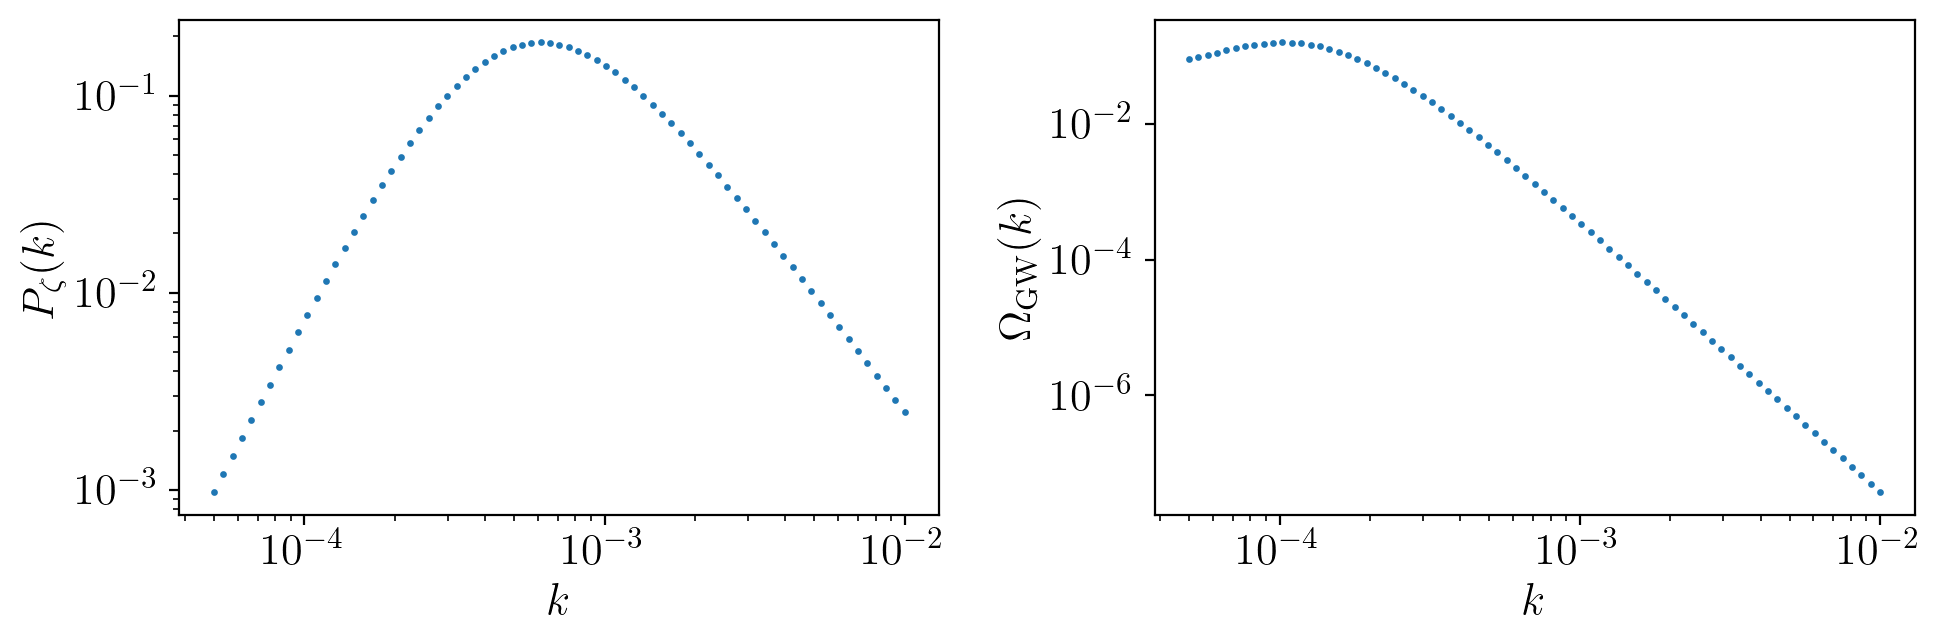

In [2]:
# set up the power spectrum and omgw
psize = 75
ksize = 75
p_arr = jnp.geomspace(5e-5,1e-2,psize)
k_arr = jnp.geomspace(5e-5,1e-2,ksize)

f = jnp.geomspace(5e-5, 1e-2, psize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 100)  # First rescaled internal momentum
t = jnp.logspace(-6, 6, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(k_arr)
omgw_amp = omgw_calculator(pz,f)

print(omgw_amp.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,omgw_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

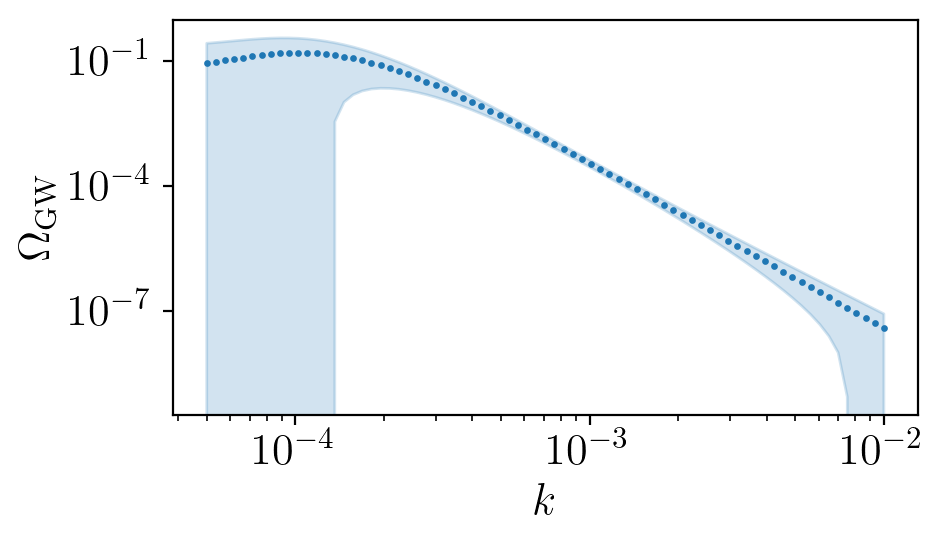

In [3]:
kstar = 1e-3
omks_sigma = omgw_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.1) # 10% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,omgw_amp,s=2)
ax.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [4]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
omgw_method_kwargs = {'s': s, 't': t}
pz_model = fixed_node_model(nbins=5,pz_kmin=kmin,pz_kmax=kmax,
                            omgw_karr=k_arr,omgw_means=omgw_amp,
                            omgw_cov=omgw_cov,omgw_method='jax',omgw_method_kwargs=omgw_method_kwargs)

In [24]:
# run the HMC
samples, _ = pz_model.run_hmc_inference(num_warmup=128,num_samples=256)

sample: 100%|██████████| 384/384 [08:39<00:00,  1.35s/it, 1 steps of size 2.18e-01. acc. prob=0.70] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -4.74      2.33     -5.45     -7.98     -1.09     78.76      1.00
      y[1]     -3.01      2.26     -2.83     -6.63      0.34     39.85      1.06
      y[2]     -6.48      1.33     -6.92     -7.99     -4.60      7.28      1.14
      y[3]     -5.41      1.17     -5.33     -7.44     -3.79     12.28      1.18
      y[4]     -6.32      0.94     -6.31     -7.79     -4.95     43.80      1.00

Number of divergences: 186


#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

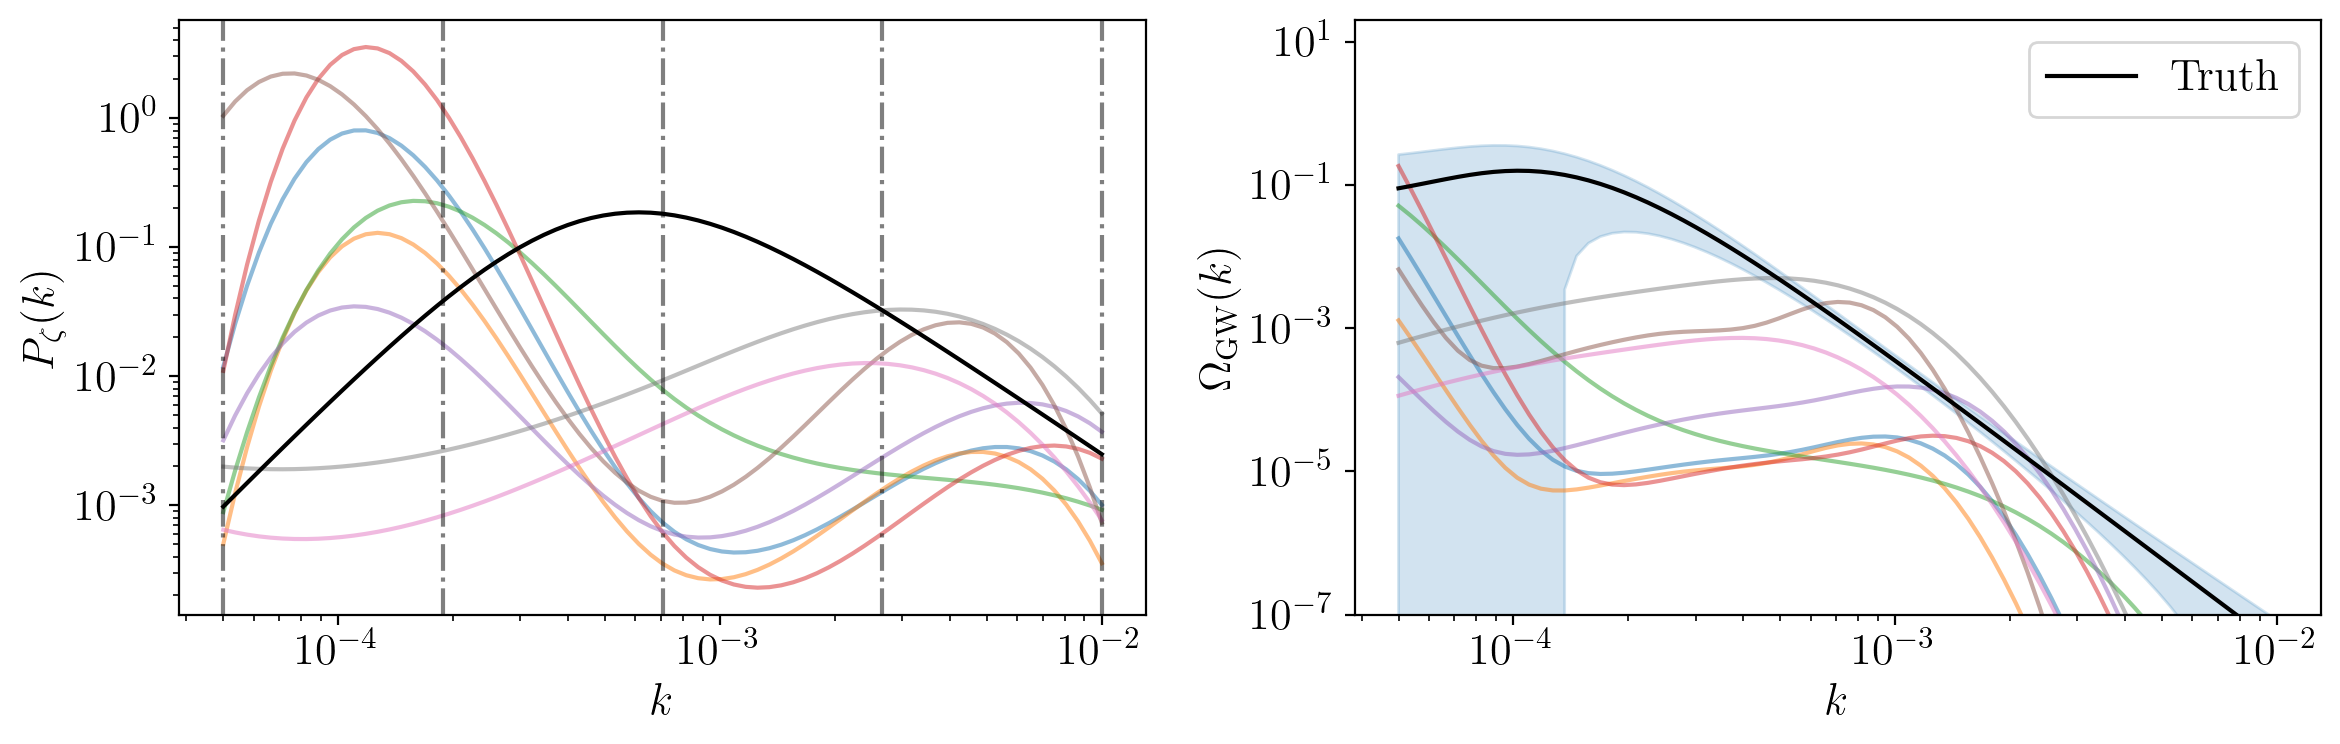

In [27]:
from src.model import spline_predict
nodes = pz_model.log_k_nodes
ys = samples['y'][::32] #jnp.median(samples['y'])
ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=f)

def omega_f(y):
    pz_func = lambda x: spline_predict(x_train=nodes,y_train=y,x_pred=x)
    res = omgw_calculator(pz_func,f)
    return res
omgw_amps = map(omega_f,ys)

ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(ys)
# print(pz_amps.shape)
# omgw_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,omgw_calculator.omkij)
# print(omgw_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for pz in pz_amps:
    ax1.loglog(p_arr,pz,alpha=0.5)
for om in omgw_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-7,2e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()

# the dashed lines represent the spline node locations

#### Do an optimization instead of HMC sampling

In [5]:
best_params, _ = pz_model.run_optimiser(x0 = -1.5*jnp.ones(5), start_learning_rate=0.3 , steps = 200, jump_sdev=1.)
print(best_params)
pz_bf = lambda x: spline_predict(x_train=nodes,y_train=best_params,x_pred=x)
omgw_bf = omgw_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)

[nan nan nan nan nan]


/Users/amk/Library/CloudStorage/OneDrive-SwanseaUniversity/Codes/SIGW_Inverse/examples/../src/omega_gw_jax.py:184: SyntaxWarning: invalid escape sequence '\e'
  """
/Users/amk/Library/CloudStorage/OneDrive-SwanseaUniversity/Codes/SIGW_Inverse/examples/../src/omega_gw_jax.py:263: SyntaxWarning: invalid escape sequence '\e'
  """
/Users/amk/Library/CloudStorage/OneDrive-SwanseaUniversity/Codes/SIGW_Inverse/examples/../src/omega_gw_jax.py:813: SyntaxWarning: invalid escape sequence '\o'
  """
/Users/amk/Library/CloudStorage/OneDrive-SwanseaUniversity/Codes/SIGW_Inverse/examples/../src/omega_gw_jax.py:838: SyntaxWarning: invalid escape sequence '\o'
  """


NameError: name 'spline_predict' is not defined

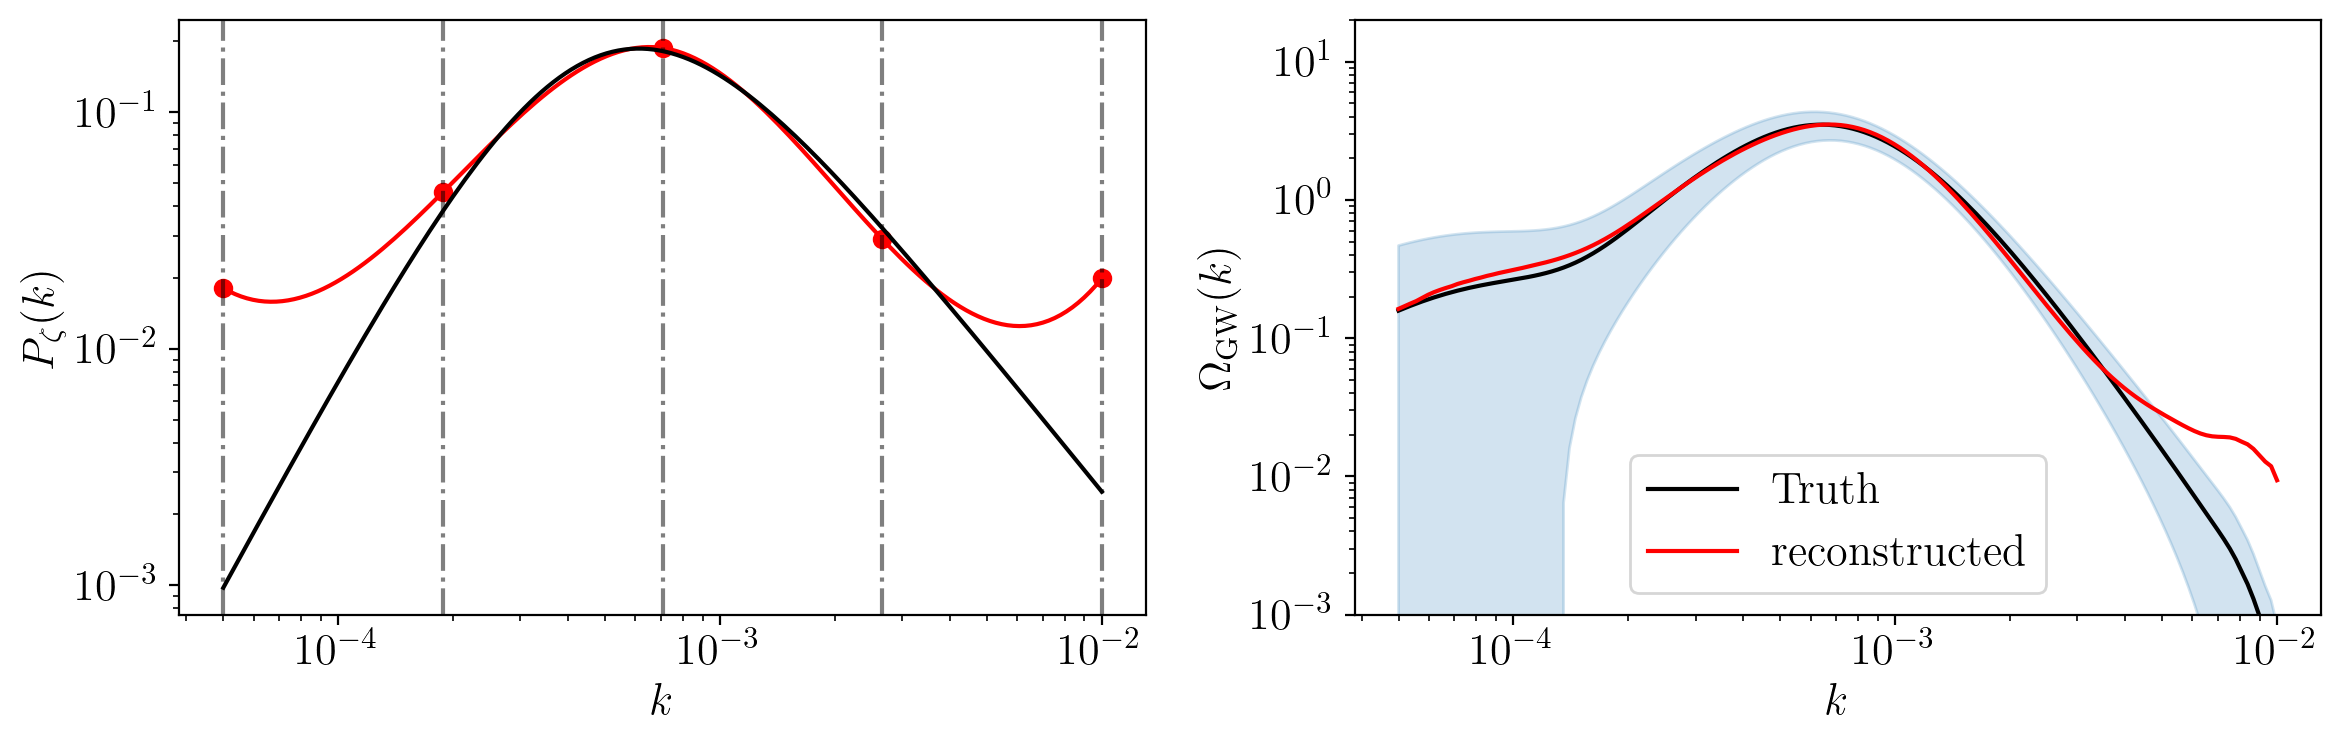

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.loglog(p_arr,pz_bf,color='r')
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.loglog(k_arr,omgw_bf,color='r',label='reconstructed')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-3,2e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
ax1.scatter(jnp.exp(nodes),jnp.exp(best_params),color='r')
fig.tight_layout()
